# XGBoost Regressor Model for S&P 500 Return Prediction

This notebook uses the combined S&P 500 dataset (2020-2025) to train an XGBoost Regressor model for predicting daily returns.

The model will predict the next day's return based on technical indicators (SMA, EMA, RSI).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, SMAIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows:
                Open      High       Low     Close                 source_file
Date                                                                          
2020-12-31  3,733.27  3,760.20  3,726.88  3,756.07  1_01012020 to 12312020.csv
2020-12-30  3,736.19  3,744.63  3,730.21  3,732.04  1_01012020 to 12312020.csv
2020-12-29  3,750.01  3,756.12  3,723.31  3,727.04  1_01012020 to 12312020.csv
2020-12-28  3,723.03  3,740.51  3,723.03  3,735.36  1_01012020 to 12312020.csv
2020-12-24  3,694.03  3,703.82  3,689.32  3,703.06  1_01012020 to 12312020.csv


In [4]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-12-31  3733.27  3760.20  3726.88  3756.07
2020-12-30  3736.19  3744.63  3730.21  3732.04
2020-12-29  3750.01  3756.12  3723.31  3727.04
2020-12-28  3723.03  3740.51  3723.03  3735.36
2020-12-24  3694.03  3703.82  3689.32  3703.06


In [5]:
# 3. Feature engineering
df["SMA_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["EMA_10"] = EMAIndicator(close=df["Close"], window=10).ema_indicator()
df["RSI"] = RSIIndicator(close=df["Close"], window=14).rsi()
df["Return"] = df["Close"].pct_change()
df["Target"] = df["Return"].shift(-1)  # Predict next day's return

print("Technical indicators created successfully!")
print(f"SMA_10 range: {df['SMA_10'].min():.2f} - {df['SMA_10'].max():.2f}")
print(f"RSI range: {df['RSI'].min():.2f} - {df['RSI'].max():.2f}")
print(f"Target (returns) range: {df['Target'].min():.6f} - {df['Target'].max():.6f}")

Technical indicators created successfully!
SMA_10 range: 2435.96 - 6309.63
RSI range: 13.43 - 91.59
Target (returns) range: -0.086886 - 0.534606


In [6]:
# 4. Drop rows with NaNs
df.dropna(inplace=True)
print(f"Dataset shape after cleaning: {df.shape}")
print(f"Remaining date range: {df.index.min()} to {df.index.max()}")

Dataset shape after cleaning: (1384, 10)
Remaining date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00


In [7]:
# 5. Prepare features and target
features = ["SMA_10", "EMA_10", "RSI"]
X = df[features]
y = df["Target"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics:")
print(X.describe())

Features shape: (1384, 3)
Target shape: (1384,)

Feature statistics:
            SMA_10       EMA_10          RSI
count  1384.000000  1384.000000  1384.000000
mean   4419.525207  4419.448541    47.625321
std     868.300661   864.196403    13.344889
min    2435.956000  2446.584367    13.427553
25%    3877.715000  3885.858096    38.018647
50%    4331.170500  4327.282532    46.301280
75%    5058.916250  5066.588830    56.293141
max    6309.629000  6207.514344    91.587615


In [8]:
# 6. Train/Test split (no shuffle for time series)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Test period: {y_test.index.min()} to {y_test.index.max()}")

Training set: 1284 samples
Test set: 100 samples
Test period: 2025-01-06 00:00:00 to 2025-05-30 00:00:00


In [9]:
# 7. Train the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("✅ Model training completed!")

✅ Model training completed!


In [10]:
# 8. Predict
y_pred = model.predict(X_test)
print(f"✅ Predictions completed!")
print(f"Predicted returns range: {y_pred.min():.6f} to {y_pred.max():.6f}")

✅ Predictions completed!
Predicted returns range: -0.011165 to 0.191057


In [11]:
# 9. Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== Model Performance ===")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test - y_pred)):.6f}")

# Additional insights
print(f"\n=== Additional Metrics ===")
print(f"Actual returns std: {y_test.std():.6f}")
print(f"Predicted returns std: {y_pred.std():.6f}")
print(f"Correlation: {np.corrcoef(y_test, y_pred)[0,1]:.4f}")

=== Model Performance ===
RMSE: 0.027445
R²: -1.7757
Mean Absolute Error: 0.013598

=== Additional Metrics ===
Actual returns std: 0.016556
Predicted returns std: 0.019863
Correlation: -0.1334


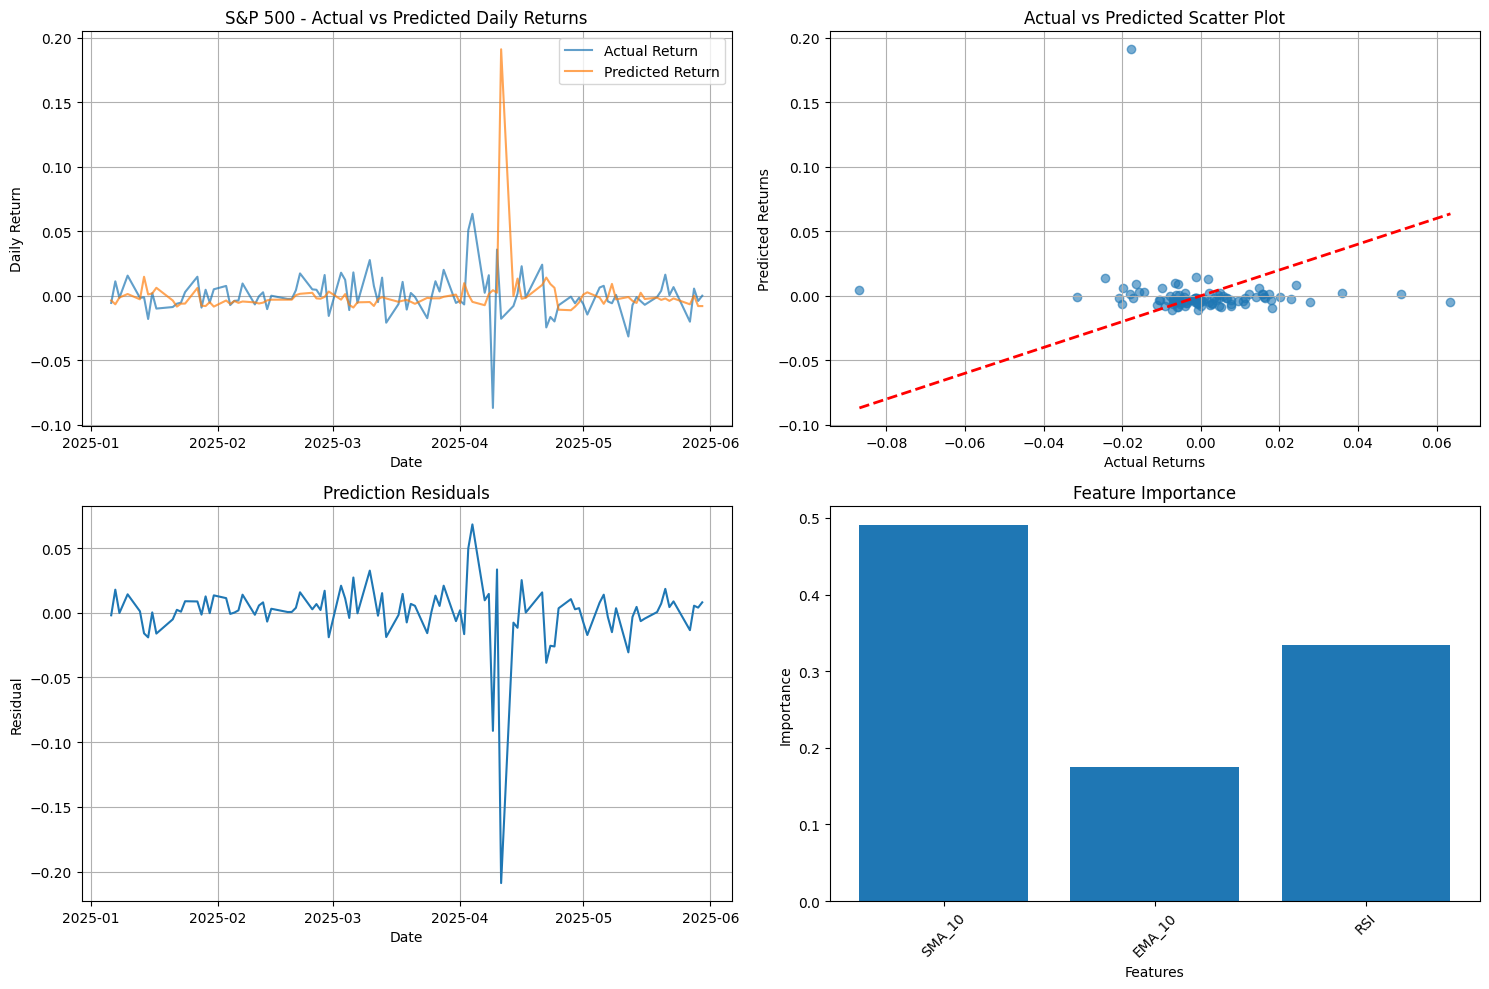

In [12]:
# 10. Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted Returns
plt.subplot(2, 2, 1)
plt.plot(y_test.index, y_test, label="Actual Return", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted Return", alpha=0.7)
plt.title("S&P 500 - Actual vs Predicted Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)

# Plot 2: Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Scatter Plot")
plt.grid(True)

# Plot 3: Residuals
plt.subplot(2, 2, 3)
residuals = y_test - y_pred
plt.plot(y_test.index, residuals)
plt.title("Prediction Residuals")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)

# Plot 4: Feature Importance
plt.subplot(2, 2, 4)
feature_importance = model.feature_importances_
plt.bar(features, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()